In [1]:
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/"My Drive"/cell-images-for-detecting-malaria.zip


Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [ ]:
infect = os.listdir('/content/cell_images/cell_images/Parasitized/')
uninfect = os.listdir('/content/cell_images/cell_images/Uninfected/')

In [5]:
data = []
labels = []

#we'll save 3 images from each image, one rotated 30º and another rotated 60° from the original

for i in infect:
    try:
    
        image = cv2.imread("/content/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated30 = resize_img.rotate(30)
        rotated60 = resize_img.rotate(60)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated30))
        data.append(np.array(rotated60))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for s in uninfect:
    try:
        
        image = cv2.imread("/content/cell_images/cell_images/Uninfected/"+s)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated30 = resize_img.rotate(30)
        rotated60 = resize_img.rotate(60)
        data.append(np.array(resize_img))
        data.append(np.array(rotated30))
        data.append(np.array(rotated60))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')


In [ ]:
celulas = np.array(data)
classes = np.array(labels)

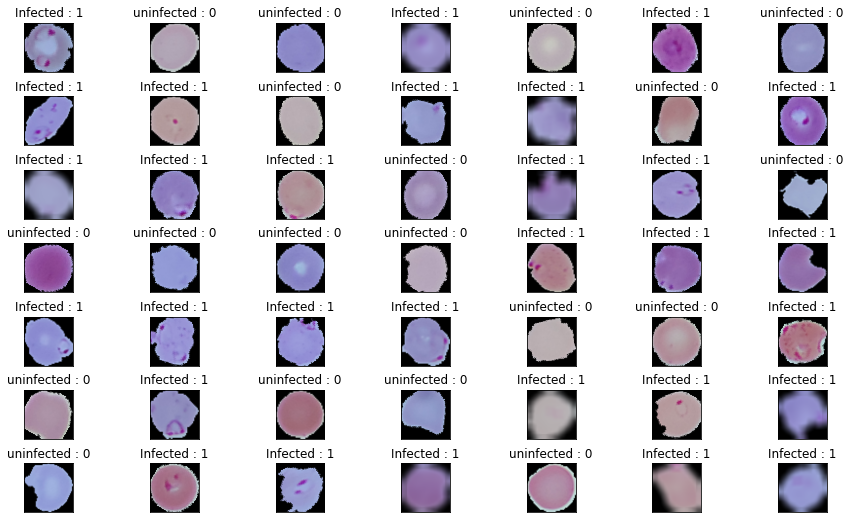

In [7]:
import matplotlib.pyplot as plt
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , celulas.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(celulas[r[0]])
    plt.title('{} : {}'.format('Infected' if classes[r[0]] == 1 else 'uninfected' ,
                               classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

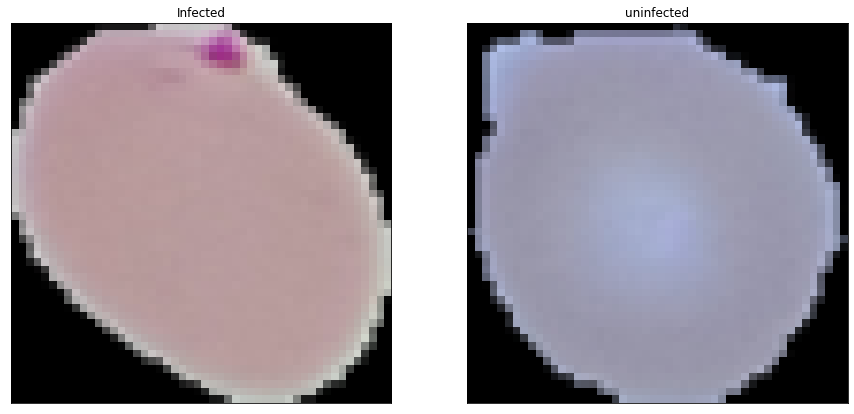

In [8]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(celulas[0])
plt.title('Infected')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(celulas[60000])
plt.title('uninfected')
plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
np.random.seed(0)

n = np.arange(celulas.shape[0])
np.random.shuffle(n)
cells = celulas[n]
labels = classes[n]

In [ ]:
cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [ ]:
from sklearn.model_selection import train_test_split

X , x_test , y , y_test = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 79)

X_tr , X_val , y_tr , y_val = train_test_split(X , y , 
                                                    test_size = 0.4 , 
                                                    random_state = 79)

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(cells)

y_tr = keras.utils.to_categorical(y_tr,num_classes)
y_val = keras.utils.to_categorical(y_val,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

In [13]:
print(y_tr.shape, y_val.shape, X_tr.shape, X_val.shape)


(46297, 2) (30865, 2) (46297, 50, 50, 3) (30865, 50, 50, 3)


# Sequential 2D CNN

In [14]:
#creating the architecture of our neural network 

model = Sequential()

model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(2,activation="sigmoid")) # we're using 0 to healthy cells and 1 to infected cells 
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         


In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
history = model.fit(X_tr,y_tr,validation_data=(X_val, y_val),batch_size=50,epochs=10,verbose=1)





Train on 46297 samples, validate on 30865 samples
Epoch 1/10





46297/46297 [==============================] - 25s 544us/step - loss: 0.2272 - acc: 0.9074 - val_loss: 0.1240 - val_acc: 0.9602
Epoch 2/10
46297/46297 [==============================] - 10s 216us/step - loss: 0.1251 - acc: 0.9598 - val_loss: 0.1181 - val_acc: 0.9620
Epoch 3/10
46297/46297 [==============================] - 10s 215us/step - loss: 0.1163 - acc: 0.9617 - val_loss: 0.1098 - val_acc: 0.9643
Epoch 4/10
46297/46297 [==============================] - 10s 215us/step - loss: 0.1094 - acc: 0.9628 - val_loss: 0.1070 - val_acc: 0.9632
Epoch 5/10
46297/46297 [==============================] - 10s 215us/step - loss: 0.1062 - acc: 0.9642 - val_loss: 0.1046 - val_acc: 0.9655
Epoch 6/10
46297/46297 [==============================] - 10s 215us/step - loss: 0.1017 - acc: 0.9647 - val_loss: 0.1065 - val_acc: 0.9648
Epoch 7/10
46297/46297 [==============================] - 10s 215us/step - loss: 0.0970 - acc: 0.9665 - val_

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)


19291/19291 [==============================] - 2s 92us/step


In [18]:
pred = model.predict(x_test, verbose=1)


19291/19291 [==============================] - 1s 75us/step


In [ ]:
from keras.models import load_model
model.save('cells.h5')

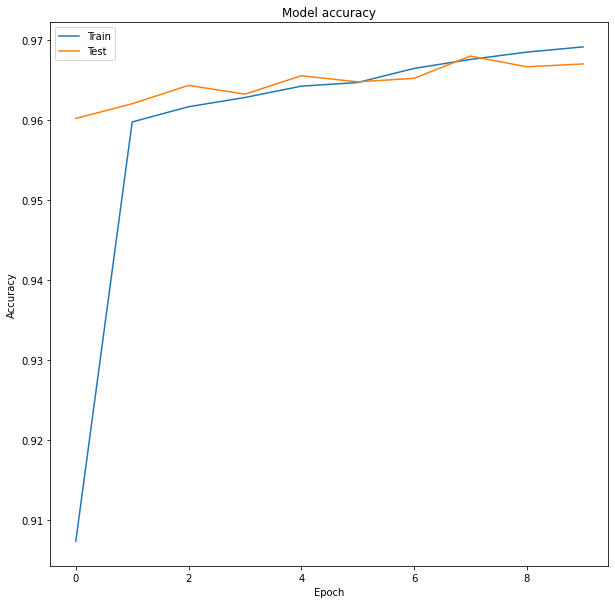

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

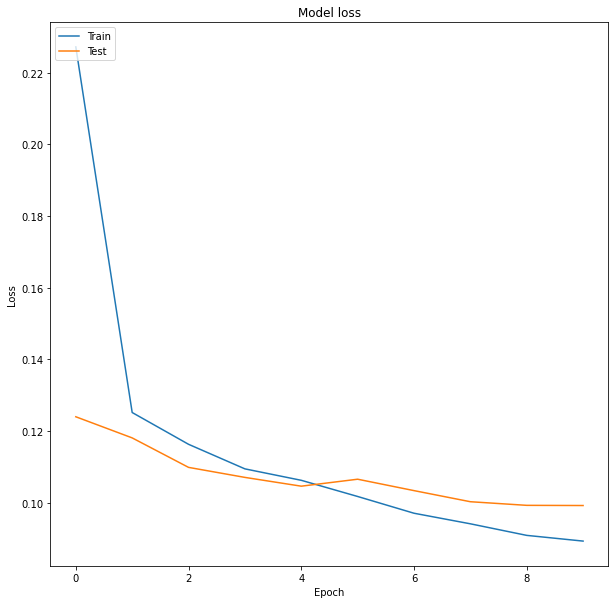

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_tr[20].reshape(1,50,50,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

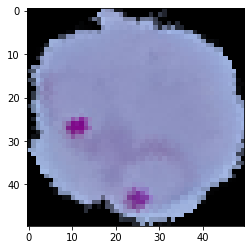

In [24]:
plt.imshow(X_tr[20][:,:,:]);


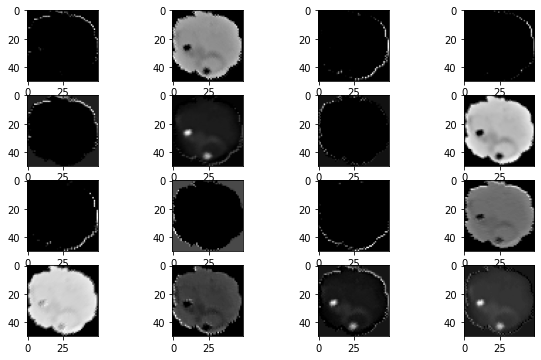

In [25]:
display_activation(activations, 4, 4, 0)


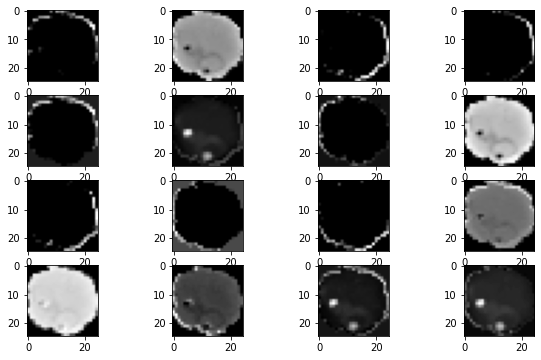

In [26]:
display_activation(activations, 4, 4, 1)


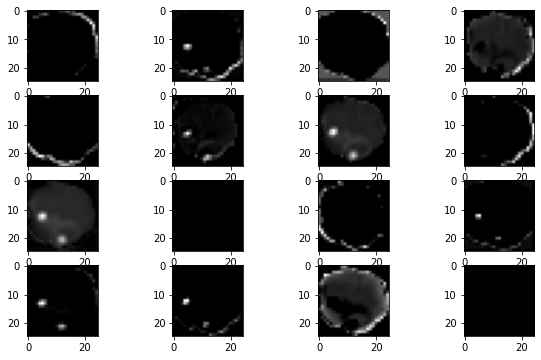

In [27]:
display_activation(activations, 4, 4, 2)


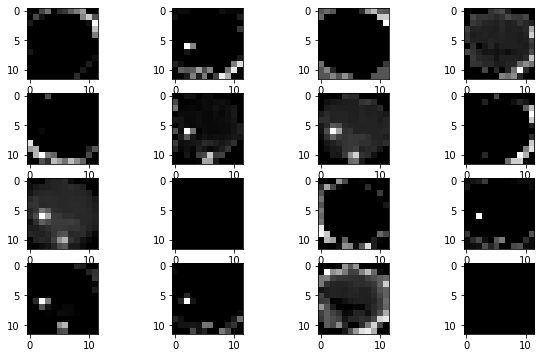

In [28]:
display_activation(activations, 4, 4, 3)


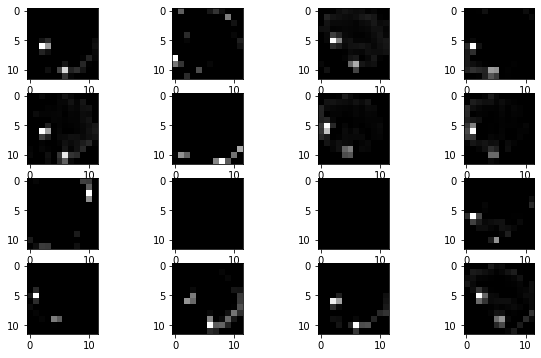

In [29]:
display_activation(activations, 4, 4, 4)


In [30]:
from sklearn import metrics
conf = metrics.confusion_matrix(y_test[:,0], np.around(pred[:,0]))
conf_norm = conf/conf.sum(axis=1)
print(conf_norm)

[[0.96175262 0.05026392]
 [0.01761753 0.97684741]]


# MobileNet


In [ ]:
from keras.applications.mobilenet import MobileNet

In [32]:
mobile_model = MobileNet(input_shape=(50,50,3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights=None, input_tensor=None, pooling=None, classes=2)

In [33]:
x = mobile_model.output
x = Flatten()(x)
preds = Dense(2,activation='softmax')(x) #final layer with softmax activation
mobile_model=Model(inputs=mobile_model.input,outputs=preds)
mobile_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 51, 51, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 25, 25, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 25, 25, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 25, 25, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 25, 25, 32)        128 

In [34]:
mobile_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
history_mobile = mobile_model.fit(X_tr,y_tr,validation_data=(X_val, y_val),batch_size=128,epochs=10,verbose=1)

Train on 46297 samples, validate on 30865 samples
Epoch 1/10
46297/46297 [==============================] - 32s 683us/step - loss: 0.5001 - acc: 0.7524 - val_loss: 0.8995 - val_acc: 0.7269
Epoch 2/10
46297/46297 [==============================] - 25s 549us/step - loss: 0.3299 - acc: 0.8495 - val_loss: 1.0192 - val_acc: 0.7474
Epoch 3/10
46297/46297 [==============================] - 26s 553us/step - loss: 0.2087 - acc: 0.9142 - val_loss: 0.1817 - val_acc: 0.9311
Epoch 4/10
46297/46297 [==============================] - 25s 549us/step - loss: 0.1353 - acc: 0.9487 - val_loss: 0.2221 - val_acc: 0.9288
Epoch 5/10
46297/46297 [==============================] - 25s 549us/step - loss: 0.1111 - acc: 0.9591 - val_loss: 0.1459 - val_acc: 0.9486
Epoch 6/10
46297/46297 [==============================] - 25s 542us/step - loss: 0.0965 - acc: 0.9642 - val_loss: 0.2024 - val_acc: 0.9200
Epoch 7/10
46297/46297 [==============================] - 25s 545us/step - loss: 0.0892 - acc: 0.9668 - val_loss: 0.

In [35]:
score_mobile = mobile_model.predict(x_test, verbose=1)




19291/19291 [==============================] - 5s 253us/step


In [36]:
conf_mob = metrics.confusion_matrix(y_test[:,0], np.around(score_mobile[:,0]))
conf_mob_norm = conf_mob/conf_mob.sum(axis=1)
print(conf_mob_norm)

[[0.93774532 0.08181382]
 [0.0182565  0.97600768]]


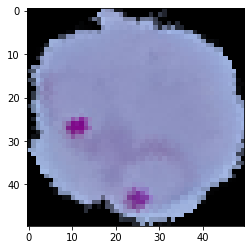

In [37]:
layer_outputs = [layer.output for layer in mobile_model.layers[1:]]
activation_model = Model(inputs=mobile_model.input, outputs=layer_outputs)
activations_mob = activation_model.predict(X_tr[20].reshape(1,50,50,3))
plt.imshow(X_tr[20][:,:,:]);

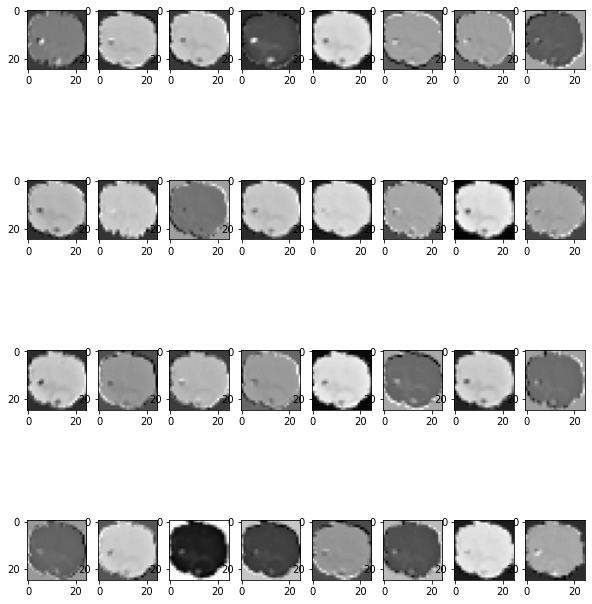

In [38]:
display_activation(activations_mob, 8, 4, 1)


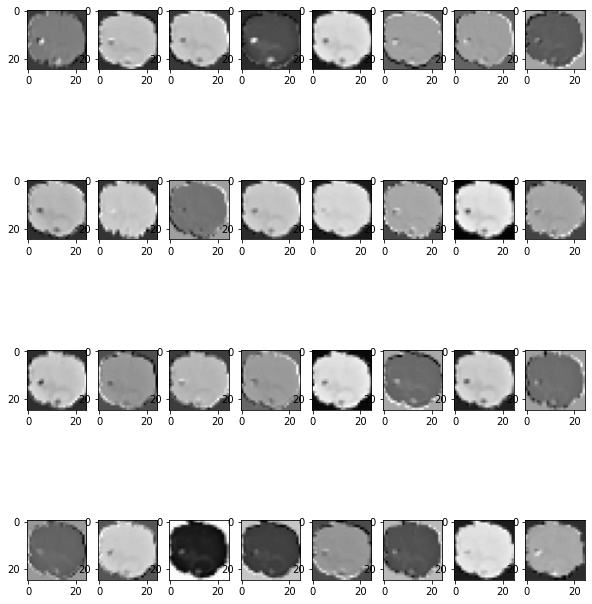

In [39]:
display_activation(activations_mob, 8, 4, 2)


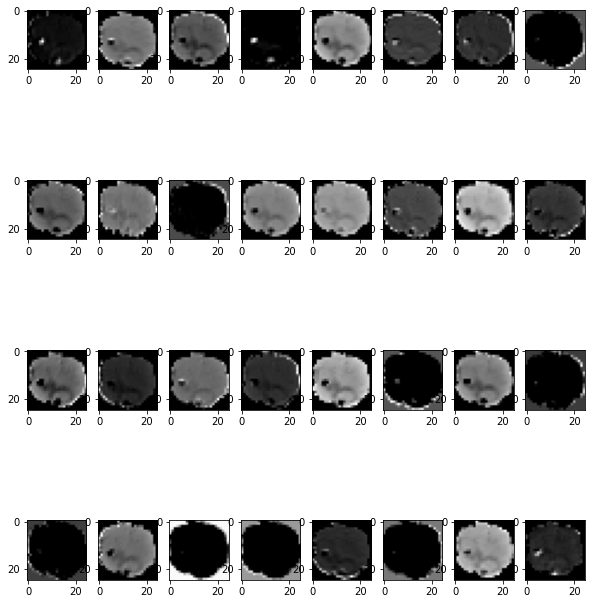

In [40]:
display_activation(activations_mob, 8, 4, 3)


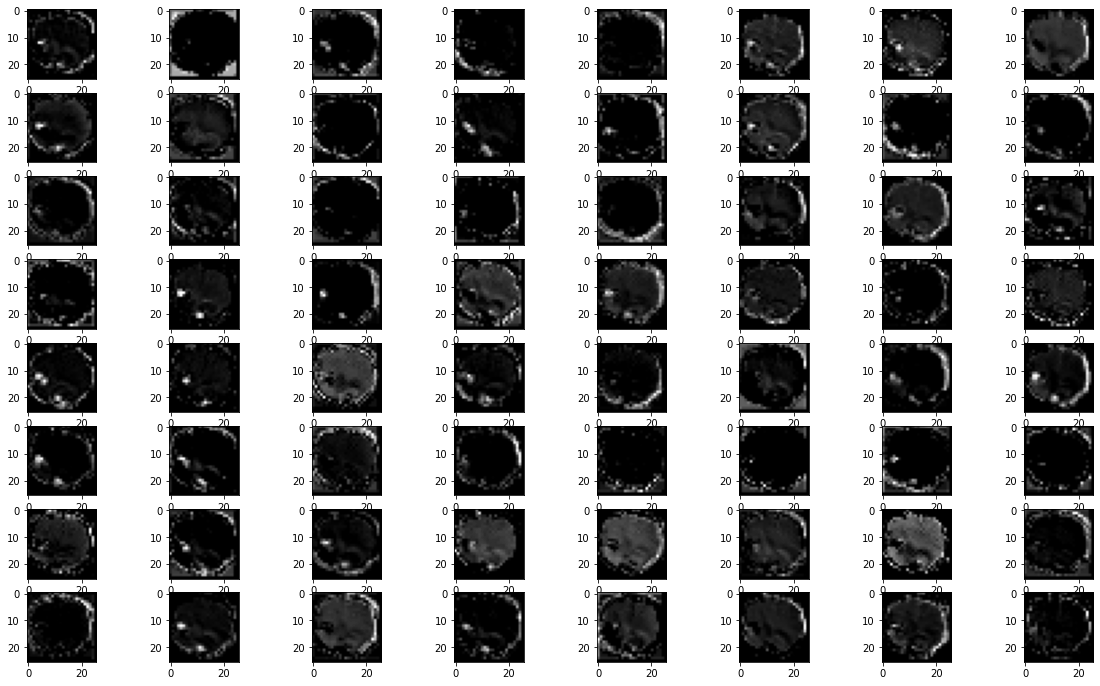

In [41]:
display_activation(activations_mob, 8, 8, 10)


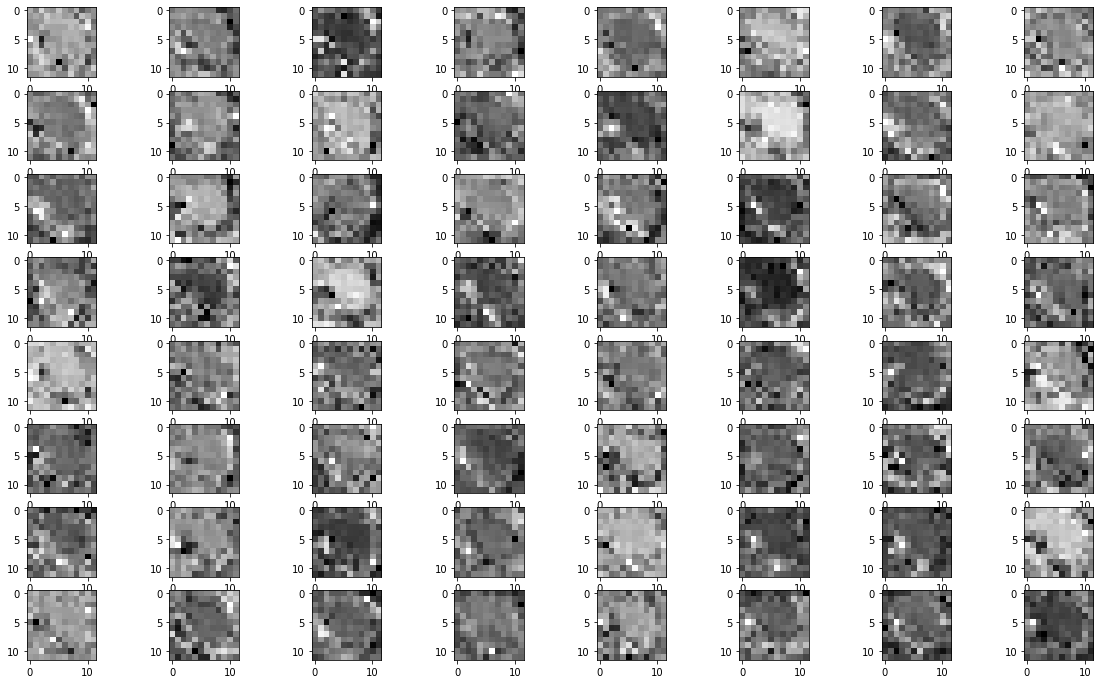

In [42]:
display_activation(activations_mob, 8, 8, 20)


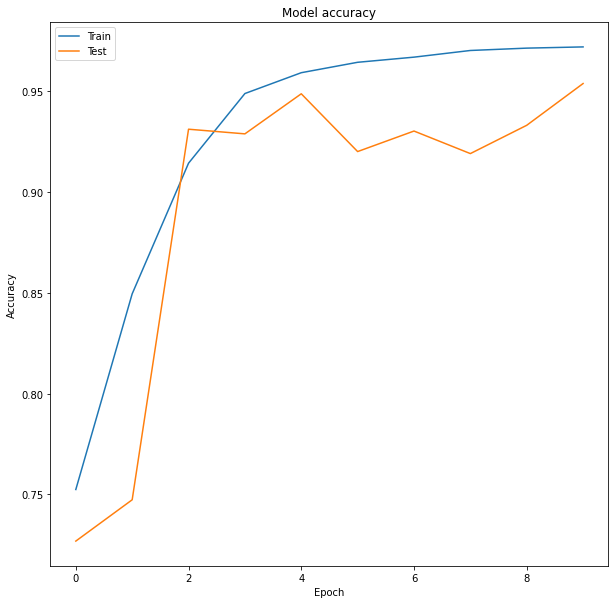

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(10,10))
plt.plot(history_mobile.history['acc'])
plt.plot(history_mobile.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

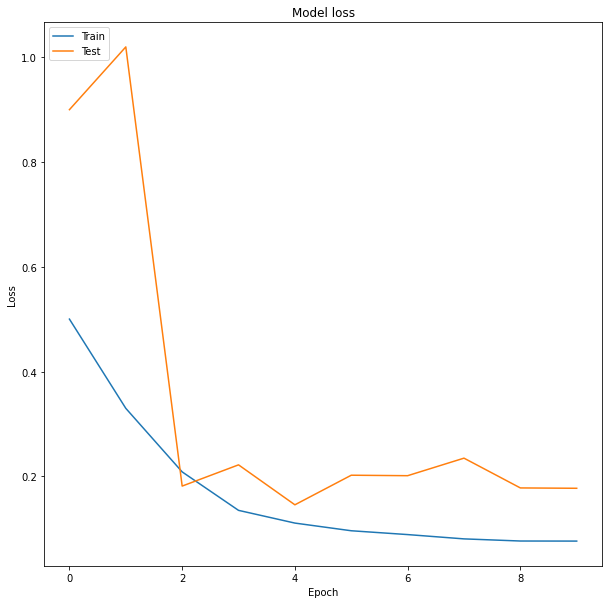

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(10,10))
plt.plot(history_mobile.history['loss'])
plt.plot(history_mobile.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
model.evaluate(x_test, y_test, verbose=1)


19291/19291 [==============================] - 2s 90us/step


[0.09397027385934047, 0.9683790368874629]

In [46]:
mobile_model.evaluate(x_test, y_test, verbose=1)


19291/19291 [==============================] - 5s 234us/step


[0.1694294586758376, 0.9542791975316348]